# Padded 1D Column Max Signals

Processes cluster data to create standardized 1D signals from column maxes. Pads variable-length cluster projections to a fixed 240-wire length based on their spatial position in the detector.

**Purpose:** Creates uniform input data for machine learning models from variable-sized particle clusters.



In [2]:
import sys
sys.path.append('..')

import uproot

import numpy as np
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.measure import label, regionprops
from scipy.ndimage import label as scipy_label
from collections import deque

from lariat import Event

In [3]:
# Threshold = 15, all connected regions. 
allclusters = pd.read_pickle("/Users/user/data/research/proton-deuteron/csv/allclusters.pkl")

# Cleaning

- length over 10 wires.

In [4]:
print(allclusters.shape)
allclusters = allclusters[allclusters['column_maxes'].map(len) > 10].reset_index(drop=True); print(allclusters.shape)

(438575, 27)
(70922, 27)


In [5]:
allclusters.describe()

,event_idx,run,subrun,event,event_index,cluster_idx,area,max_intensity,min_intensity,mean_intensity,...,centroid_x,centroid_y,bbox_min_row,bbox_min_col,bbox_max_row,bbox_max_col,width,height,aspect_ratio,compactness
count,70922.000000,70922.000000,70922.000000,70922.000000,70922.000000,70922.000000,70922.000000,70922.000000,70922.000000,70922.000000,...,70922.000000,70922.000000,70922.000000,70922.000000,70922.000000,70922.000000,70922.000000,70922.000000,70922.000000,70922.000000
mean,3569.440385,9162.896971,181.005175,15761.972124,0.202448,14.664519,3804.938031,255.512055,16.000127,62.785274,...,96.854315,1370.555077,54.300795,1260.438284,139.625349,1490.783537,230.345253,85.324554,4.083365,0.255385
std,2062.730808,436.903703,133.143643,11933.709622,0.471958,35.012518,5090.749907,195.276959,0.012453,30.400408,...,51.895531,757.965514,54.504024,770.850172,67.826323,755.235368,203.807723,66.519643,4.411272,0.145331
min,0.000000,8557.000000,1.000000,11.000000,0.000000,0.000000,20.000000,18.000000,16.000000,16.375000,...,3.287313,0.800000,0.000000,0.000000,11.000000,4.000000,3.000000,11.000000,0.147826,0.016106
25%,1772.000000,8681.000000,67.000000,5692.000000,0.000000,0.000000,1002.000000,116.000000,16.000000,38.685857,...,51.402100,870.247113,20.000000,740.000000,75.000000,1015.000000,105.000000,28.000000,1.632088,0.141910
50%,3545.000000,9452.000000,154.000000,13217.500000,0.000000,2.000000,2311.000000,212.000000,16.000000,54.544794,...,92.251308,1221.996050,29.000000,1127.000000,136.000000,1335.000000,177.000000,61.000000,2.906250,0.224961
75%,5341.750000,9510.000000,278.000000,23421.000000,0.000000,13.000000,4776.000000,333.000000,16.000000,80.622537,...,130.313502,1819.151759,73.000000,1714.000000,208.000000,1944.000000,288.000000,140.000000,4.894737,0.344149
max,7635.000000,9788.000000,624.000000,52920.000000,5.000000,507.000000,184515.000000,2354.000000,18.000000,352.780189,...,234.916084,3070.625000,229.000000,3069.000000,240.000000,3072.000000,3072.000000,240.000000,132.384615,0.901010


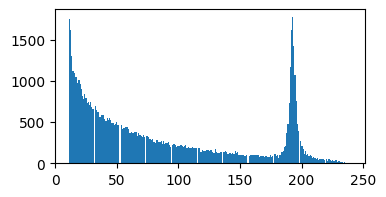

In [6]:
plt.figure(figsize=(4,2)); plt.hist(allclusters['column_maxes'].apply(len), bins=240); plt.show()

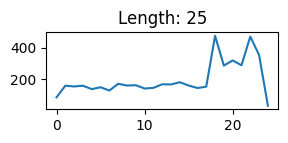

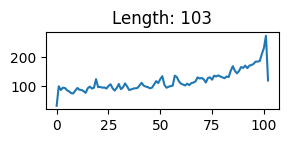

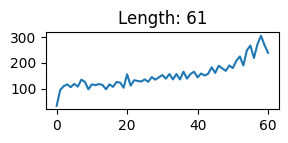

In [7]:
sample = allclusters['column_maxes'].sample(3)

for i, sample in enumerate(sample):
    plt.figure(figsize=(3,1)); plt.plot(sample); plt.title(f"Length: {len(sample)}") 

# Padding function for 'column_maxes'

In [8]:
def padding(column_maxes, min, max, target=240):
    
    signal = np.array(column_maxes); length = len(signal)
    zeros = np.zeros(target)
    span = max - min + 1
    
    if length != span:
        if abs(length - span) > 2:
            print(f"Length {length} != Span {span}")
    
    start = min
    end = min + length

    zeros[start:end] = signal[0:length]
    
    padded = zeros

    return padded

In [9]:
data = []

for idx, row in allclusters.iterrows():
    padded_signal = padding(
        row['column_maxes'],
        row['bbox_min_row'],
        row['bbox_max_row']
    )
    data.append(padded_signal)

data = np.array(data)

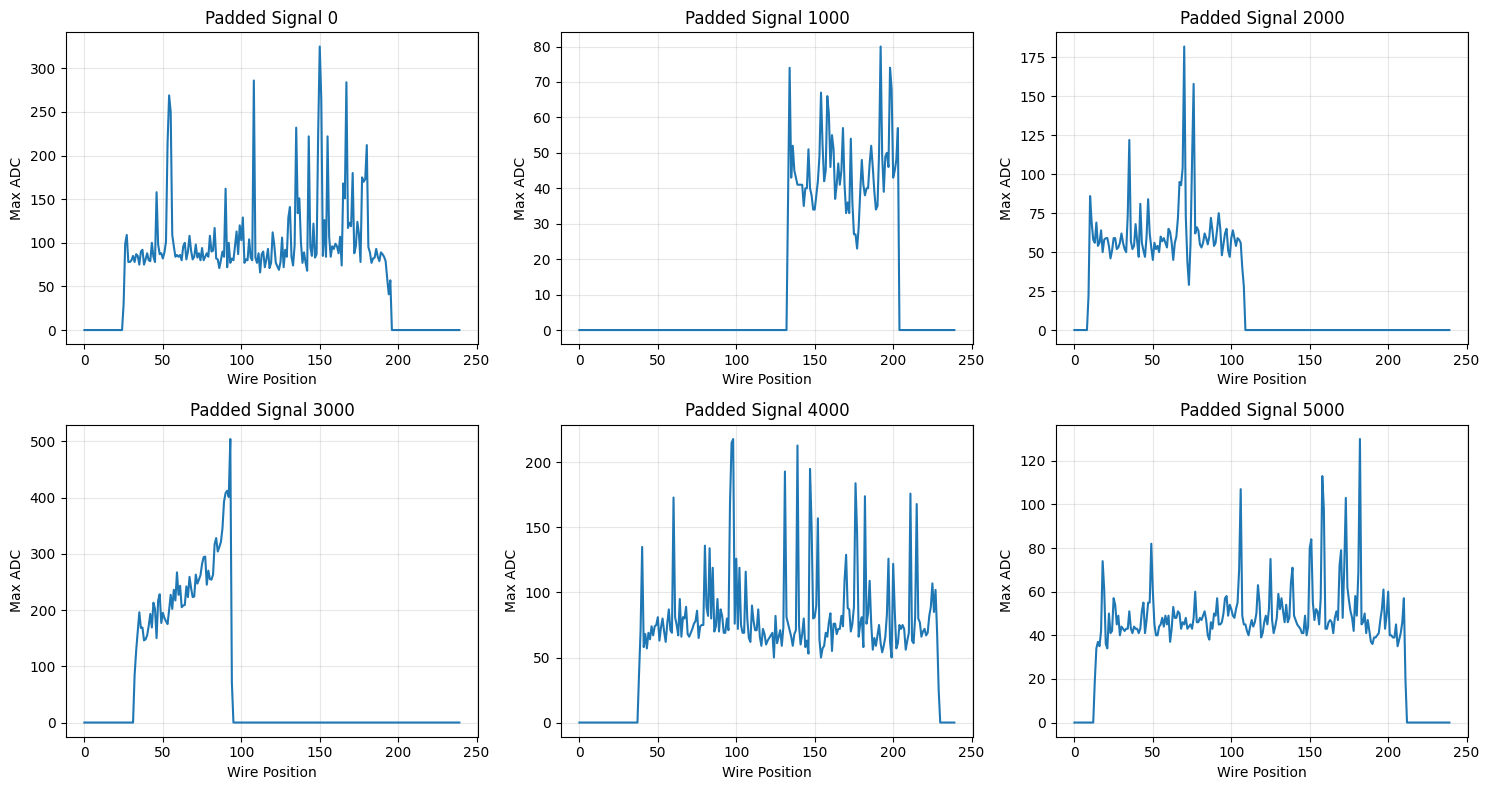

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i in range(6):
    ax = axes[i]
    signal = data[i * 1000]
    ax.plot(signal)
    ax.set_title(f'Padded Signal {i * 1000}')
    ax.set_xlabel('Wire Position')
    ax.set_ylabel('Max ADC')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
data

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [60., 91., 85., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [12]:
np.save('padded_max_adc_columns.npy', data)